In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.special import erfinv
from scipy.special import erf
import corner
import yaml
import generate_emulator as ge
import gpflow
import h5py
import sys
import os
import copy
import get_fsps_phot as gfp

plt.rc('text', usetex=True)
plt.rc('font',size=36)
%pylab inline

/home/will/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/will/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
/home/will/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def priortransform(cube_arr):
        # definition of the parameter width, by transforming from a unit cube - switched redshift to be the last index
        # skip this, emu on unit cube
        cube = cube_arr.copy()
        cube[0] = cube_arr[0] * 5.5 + 7.
        ##cube[0] = 10**(cube[0] * 5.5 - 3) # basically, this sets bounds on the mass: 7 to 12.5 -> -3 to 2 (A=1 -> 10^10)
        cube[1] = cube_arr[1] * 10 # mu: 0 to 10
        cube[2] = cube_arr[2] * 4.8 + 0.2 # sigma: 0.2 to 5 # NEED TO ALLOW SMALLER VALUES
        ##cube[3] = cube[3] * 10 # z: 0 to 10
        cube[3] = 10**(0.3 * erfinv(2.*(cube_arr[3]-0.5))) # metallicity scatter: Gaussian about 0, sigma = 0.3 dex - pinch this at some limiting values - 0.001, 0.999??
        cube[4] = cube_arr[4] * 2.  # dust extinction (doubled in birth clouds): 0 to 2.
        cube[5] = 10**(cube_arr[5]) - 1. # log-spaced redshift sampling, z: 0 to 9.
        ##cube[5] = cube[5] # z: 0 to 9. The log spacing is set earlier, so we just output the same value
        return cube
    
def untransform(cube_arr):
        cube = cube_arr.copy()
        cube[0] = (cube_arr[0] -7.) /  5.5
        cube[1] = cube_arr[1] / 10 # mu: 0 to 10
        cube[2] = (cube_arr[2] - 0.2) / 4.8 # sigma: 0.2 to 5 
        cube[3] = erf(np.log10(cube_arr[3]) / 0.3)/2. + 0.5 # metallicity scatter: Gaussian about 0, sigma = 0.3 dex - pinch this at some limiting values - 0.001, 0.999??
        cube[4] = cube_arr[4] / 2.  # dust extinction (doubled in birth clouds): 0 to 2.
        cube[5] = np.log10(cube_arr[5] + 1.) # log-spaced redshift sampling, z: 0 to 9.
        return cube
    
def gauss(x, z, A, mu, sig):
    return A * exp(-0.5 * ((mu - x / (1. + z))/sig)**2)

#def get_mod_phot(A, mu, sig, met, dust, z):
#    y, yerr = mod.predict_y(np.array([A, mu, sig, met, dust, z]).reshape(1,-1))
#    return 10**((30.-y[0,:12])/2.5)

def get_mod_phot(pars):
    y, yerr = mod.predict_y(pars.reshape(1,-1))
    return 10**((30.-y[0,:12])/2.5)

In [3]:
# pick which object (for testing)
i_obj = 46

# read yaml
config = yaml.load(open("grid.yaml"))

# read in the emulator, compute it if needed. Pickling the object doesn't seem to work?
if config['train_emu'] == True:
    mod = ge.make_emulator_GPflow()
else:
    mod = ge.load_emulator_GPflow()

# load data
ndata = 100
if ndata > 0:
    with h5py.File("UDS_DR11_spec.h5", 'r') as f:
        x = np.array(f['x'].value)
        y = np.array(f['y'][:,:ndata])
else:
    with h5py.File("UDS_DR11_spec.h5", 'r') as f:
        x = np.array(f['x'].value)
        y = np.array(f['y'].value)

nx, ndata = y.shape
# y has fluxes followed by flux errors.

# we want to add systematic errors to the photometry, by band:
bands = ['u','B','V','R','i','z','Y','J','H','K','I1','I2']
syst_errs = np.array([0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.1, 0.1])
y[int(nx/2):,:] = np.sqrt((y[int(nx/2):,:]*y[int(nx/2):,:]) + (np.tile(syst_errs, ndata).reshape((ndata,int(nx/2))).T * y[:int(nx/2),:])**2)
waves = np.array([3796.11571888, 4458.05618762, 5477.41955513, 6532.37444814, 7682.94106106, 9036.67456649, 10212.72604114, 12510.43831574, 16387.79389646, 22084.84812739, 35572.60440514, 44976.10885919])


params = ['A', 'mu', 'sig', 'met', 'tau', 'z']
nparams = len(params)

print(y.shape)
# length of data vector
n = len(y[:int(nx/2),i_obj])

fluxes = y[:int(nx/2),i_obj]
flux_errs = y[int(nx/2):,i_obj]
print(fluxes)

(2000, 22) (2000, 6)
(2000, 22) (2000, 6) float32 float32


INFO:tensorflow:Restoring parameters from ./model.ckpt


INFO:tensorflow:Restoring parameters from ./model.ckpt


(24, 100)
[ 113.59124425  152.07282589  280.44159409  455.1680977   914.18239103
 1319.92291085 1634.51182869 2688.70421816 3544.20375418 5548.22170976
 7994.54086543 6039.96450056]


In [4]:
# Get the MAP, as output by multinest
tmp = []
with open("test2_summary.txt") as f:
    for line in f:
        tmp.append(line.split())
MAP = np.array(tmp[0][12:18], dtype=float64)
MAP

array([0.61972037, 0.93692413, 0.21792744, 0.99041568, 0.99346398,
       0.2732375 ])

In [5]:
# convert unit cube to physical values
MAP_phys = priortransform(MAP)
MAP_phys

array([10.40846203,  9.36924132,  1.24605172,  3.13951876,  1.98692796,
        0.87602017])

In [6]:
# Now get the photometry at the MAP point
#MAP = np.array([0.8,0.5,0.5,0.5,0.5,0.5])
print(MAP)
ypred = get_mod_phot(MAP)
print(ypred)
#MAP = np.array([2.07e-01, 3.30e-01, 9.61e-05, 2.22e-03, 6.92e-02, 4.27e-01])
#ypred = get_mod_phot(MAP)
#print(ypred)

[0.61972037 0.93692413 0.21792744 0.99041568 0.99346398 0.2732375 ]
[ 110.27274769  156.2291163   258.19613285  455.2624498   926.94230089
 1459.11278625 1734.82766928 2314.2791504  3664.68553198 5319.81446096
 7330.18005949 6265.86441223]


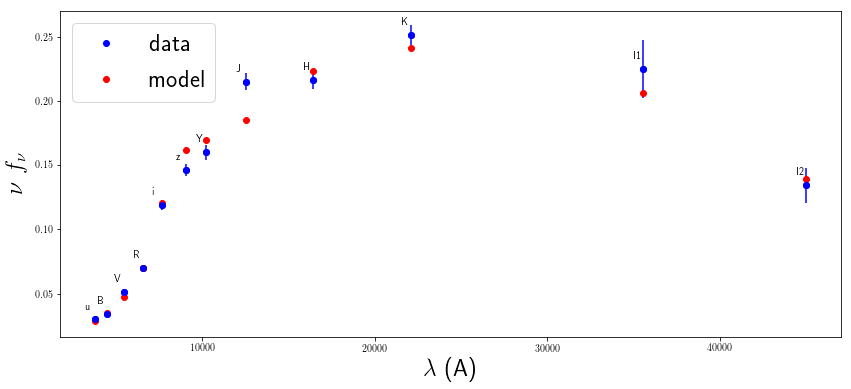

In [7]:
labels = ['u', 'B', 'V', 'R', 'i', 'z', 'Y', 'J', 'H', 'K', 'I1', 'I2']
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.plot(waves,fluxes/waves,'o',c='blue', label='data')
ax.errorbar(waves,fluxes/waves,yerr=flux_errs/waves,c='blue',fmt='o')
ax.plot(waves,ypred/waves,'o',c='red', label='model')
ax.set_xlabel('$\lambda$~(A)', fontsize='24')
ax.set_ylabel(r"$\nu~f_{\nu}$", fontsize='24')
#ax.set_yscale('log')
for i,j,k in zip(waves,fluxes/waves,labels):
    ax.annotate('%s' %k, xy=(i,j), xytext=(-10,10), textcoords='offset points')
ax.legend(fontsize='24')

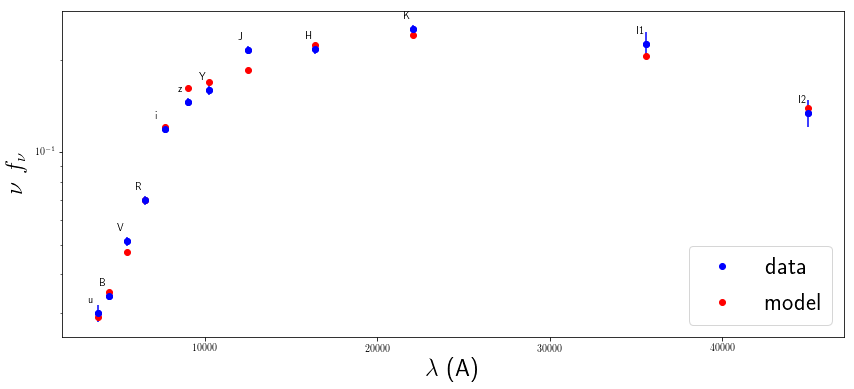

In [8]:
labels = ['u', 'B', 'V', 'R', 'i', 'z', 'Y', 'J', 'H', 'K', 'I1', 'I2']
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.plot(waves,fluxes/waves,'o',c='blue', label='data')
ax.errorbar(waves,fluxes/waves,yerr=flux_errs/waves,c='blue',fmt='o')
ax.plot(waves,ypred/waves,'o',c='red', label='model')
ax.set_xlabel('$\lambda$~(A)', fontsize='24')
ax.set_ylabel(r"$\nu~f_{\nu}$", fontsize='24')
ax.set_yscale('log')
for i,j,k in zip(waves,fluxes/waves,labels):
    ax.annotate('%s' %k, xy=(i,j), xytext=(-10,10), textcoords='offset points')
ax.legend(fontsize='24')

In [9]:
#['A', 'mu', 'sig', 'met', 'tau', 'z']
#phys = np.array([10.1, 1.29961661, 0.30046134, 0.24921502, 0.4233902, 3.438])
#cube_loc = untransform(phys)
#print(cube_loc)
#ypred = get_mod_phot(cube_loc)
#print(ypred)

In [10]:
#labels = ['u', 'B', 'V', 'R', 'i', 'z', 'Y', 'J', 'H', 'K', 'I1', 'I2']
#fig = plt.figure(figsize=(14,6))
#ax = fig.add_subplot(111)
#ax.plot(waves,fluxes/waves,'o',c='blue', label='data')
#ax.errorbar(waves,fluxes/waves,yerr=flux_errs/waves,c='blue',fmt='o')
#ax.plot(waves,ypred/waves,'o',c='red', label='model')
#ax.set_xlabel('$\lambda$~(A)', fontsize='24')
#ax.set_ylabel(r"$\nu~f_{\nu}~({\rm erg~s^{-1}~cm^{-2}})$", fontsize='24')
#ax.set_yscale('log')
#for i,j,k in zip(waves,fluxes/waves,labels):
#    ax.annotate('%s' %k, xy=(i,j), xytext=(-10,10), textcoords='offset points')
#ax.legend(fontsize='24')

In [11]:
# we actually want the spectrum to plot.
wave, spec = gfp.get_fsps_spec(MAP)
f_test = gfp.get_fsps_fluxes(MAP)

ok
still ok
[26.53234565 26.10477747 25.34981232 24.73962079 23.6854042  23.19886528
 22.98491943 22.64253567 22.05875078 21.54838273 21.08161541 21.25535665
 26.40511829 25.82984508 24.7750076  23.59370453 23.175446   23.05231027
 22.98454487 22.64075227 22.04843273 21.58294605]
got spectrum
10.408462034792976 30478662537.062634 2.1644488456622697e-07


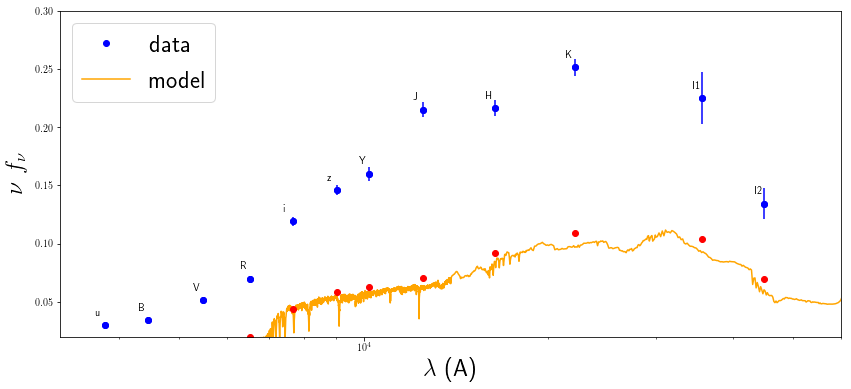

In [12]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.plot(waves,fluxes/waves,'o',c='blue', label='data')
ax.errorbar(waves,fluxes/waves,yerr=flux_errs/waves,c='blue',fmt='o')
ax.plot(wave,spec/wave,'-',c='orange', label='model')
ax.plot(waves,10**((30.-f_test[:12])/2.5) / waves,'o',c='red')
ax.set_xlabel('$\lambda$~(A)', fontsize='24')
ax.set_ylabel(r"$\nu~f_{\nu}$", fontsize='24')
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([3200.,60000.])
ax.set_ylim([0.02,0.3])
for i,j,k in zip(waves,fluxes/waves,labels):
    ax.annotate('%s' %k, xy=(i,j), xytext=(-10,10), textcoords='offset points')
ax.legend(fontsize='24')

In [13]:
print(spec)

[5.40934707e-19 1.28492052e-18 2.67827613e-18 ... 4.82614720e+01
 4.69845342e+01 4.57729258e+01]
